# Anime Recommedation Project

In [1]:
import pandas as pd
pd.set_option('display.max_columns',50)
import re
import matplotlib.pyplot as plt
import numpy as np
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise import accuracy

### Data Cleanup

In [2]:
anime_df_no_syn = pd.read_csv('./Anime_data/anime.csv')

In [3]:
anime_df_no_syn.head(5)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925,146918,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...","Funimation, Bandai Entertainment",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378,33719,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,"TV Tokyo, Dentsu",Unknown,Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108,3394,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [4]:
anime_df_no_syn.isna().sum()

MAL_ID           0
Name             0
Score            0
Genres           0
English name     0
Japanese name    0
Type             0
Episodes         0
Aired            0
Premiered        0
Producers        0
Licensors        0
Studios          0
Source           0
Duration         0
Rating           0
Ranked           0
Popularity       0
Members          0
Favorites        0
Watching         0
Completed        0
On-Hold          0
Dropped          0
Plan to Watch    0
Score-10         0
Score-9          0
Score-8          0
Score-7          0
Score-6          0
Score-5          0
Score-4          0
Score-3          0
Score-2          0
Score-1          0
dtype: int64

In [5]:
anime_df_no_syn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

In [6]:
anime_df_no_syn.describe()

,MAL_ID,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch
count,17562.000000,17562.000000,1.756200e+04,17562.000000,17562.000000,1.756200e+04,17562.000000,17562.000000,17562.000000
mean,21477.192347,8763.452340,3.465854e+04,457.746270,2231.487758,2.209557e+04,955.049653,1176.599533,8199.831227
std,14900.093170,5059.327278,1.252821e+05,4063.473313,14046.688133,9.100919e+04,4275.675096,4740.348653,23777.691963
min,1.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000
25%,5953.500000,4383.500000,3.360000e+02,0.000000,13.000000,1.110000e+02,6.000000,37.000000,112.000000
50%,22820.000000,8762.500000,2.065000e+03,3.000000,73.000000,8.175000e+02,45.000000,77.000000,752.500000
75%,35624.750000,13145.000000,1.322325e+04,31.000000,522.000000,6.478000e+03,291.750000,271.000000,4135.500000
max,48492.000000,17565.000000,2.589552e+06,183914.000000,887333.000000,2.182587e+06,187919.000000,174710.000000,425531.000000


In [7]:
anime_df_no_syn[anime_df_no_syn['Members']<100]

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
9003,23729,Minna Tomodachi,Unknown,"Comedy, Fantasy, Kids",Unknown,みんな友だち,OVA,1,2003,Unknown,Unknown,Unknown,Unknown,Unknown,15 min.,G - All Ages,15577.0,16781,99,0,5,24,2,33,35,3.0,Unknown,1.0,1.0,1.0,1.0,1.0,Unknown,1.0,2.0
9815,28577,Makehen de! Roku-nen San-kumi no Hanshin Daish...,Unknown,"Drama, Historical, Kids",Unknown,負けへんで！ ６年３組の阪神大震災,OVA,1,1996,Unknown,Unknown,Unknown,Unknown,Unknown,23 min.,G - All Ages,15377.0,16803,98,0,6,23,1,34,34,4.0,Unknown,2.0,1.0,1.0,1.0,Unknown,Unknown,Unknown,2.0
10760,30976,Kiminari Dousuru? Yuukai Itazura: Sarenai Tame ni,Unknown,"Drama, Kids",Unknown,きみならどうする？ゆうかい・いたずら されないために,OVA,1,2006,Unknown,Unknown,Unknown,Unknown,Unknown,13 min.,G - All Ages,15024.0,16852,95,0,6,24,1,36,28,3.0,1.0,Unknown,5.0,Unknown,Unknown,Unknown,Unknown,Unknown,1.0
10784,31009,Mebuki,Unknown,"Drama, Kids",Unknown,芽吹き,OVA,1,1994,Unknown,Unknown,Unknown,Unknown,Unknown,41 min.,G - All Ages,15486.0,16809,97,1,5,26,3,35,28,8.0,Unknown,2.0,2.0,1.0,Unknown,1.0,1.0,Unknown,1.0
10786,31015,Kakusensou,Unknown,"Drama, Historical, Kids",Unknown,核戦争,OVA,1,2000,Unknown,Unknown,Unknown,Unknown,Unknown,15 min.,G - All Ages,14820.0,16829,95,0,6,23,2,32,32,3.0,1.0,2.0,3.0,1.0,Unknown,Unknown,1.0,Unknown,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17524,48097,Wan Jie Qi Yuan,Unknown,"Martial Arts, Fantasy",Unknown,万界奇缘,ONA,40,"Feb 17, 2021 to ?",Unknown,iQIYI,Unknown,Ruo Hong Culture,Original,7 min. per ep.,PG-13 - Teens 13 or older,12808.0,16905,95,1,43,0,5,6,41,1.0,Unknown,1.0,1.0,1.0,1.0,1.0,Unknown,2.0,Unknown
17533,48374,Fei Ren Zai 4th Season,Unknown,"Slice of Life, Comedy, Supernatural",Unknown,非人哉 第四季,ONA,12,"Feb 3, 2021 to Apr 14, 2021",Unknown,Unknown,Unknown,Unknown,Manga,5 min. per ep.,PG-13 - Teens 13 or older,13980.0,16948,93,1,19,0,5,6,63,1.0,1.0,2.0,1.0,Unknown,Unknown,Unknown,Unknown,Unknown,1.0
17535,48391,Mazica Party,Unknown,"Game, Magic, Fantasy",Unknown,マジカパーティ,TV,Unknown,"Apr 4, 2021 to ?",Spring 2021,Unknown,Unknown,OLM,Original,Unknown,Unknown,Unknown,17471,58,2,0,0,0,0,58,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
17539,48411,Aria the Benedizione,Unknown,"Sci-Fi, Slice of Life, Fantasy, Shounen",Unknown,ARIA The BENEDIZIONE,Unknown,1,Unknown,Unknown,Unknown,Unknown,Unknown,Manga,Unknown,PG-13 - Teens 13 or older,Unknown,17530,75,0,0,0,0,0,75,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


### Filling in the English names column

In [8]:
anime_df_no_syn['Cleaned_Name'] = [anime_df_no_syn['English name'][x] if anime_df_no_syn['English name'][x] != 'Unknown' 
                else (anime_df_no_syn['Name'][x] if anime_df_no_syn['Name'][x] != 'Unknown'
                else anime_df_no_syn['Japanese name']) for x in range(len(anime_df_no_syn['English name']))]

In [9]:
anime_df_no_syn[['Name', 'English name', 'Japanese name', 'Cleaned_Name']].head()

,Name,English name,Japanese name,Cleaned_Name
0,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,Cowboy Bebop
1,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Cowboy Bebop:The Movie
2,Trigun,Trigun,トライガン,Trigun
3,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),Witch Hunter Robin
4,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,Beet the Vandel Buster


### Changing Aired column to Datetime

In [10]:
anime_df_no_syn['Aired'][0][7:11]

'1998'

In [11]:
pattern = '\d{4}'
re.findall(pattern, anime_df_no_syn['Aired'][0])

['1998', '1999']

In [12]:
anime_df_no_syn['Year_Premiered'] = [re.findall(pattern, anime_df_no_syn['Aired'][x]) for x in range(len(anime_df_no_syn['Aired']))]




In [13]:
anime_df_no_syn['Year_Premiered'] = [['Unknown'] if len(anime_df_no_syn['Year_Premiered'][x]) == 0
                                     else anime_df_no_syn['Year_Premiered'][x]
                                     for x in range(len(anime_df_no_syn['Year_Premiered']))]

In [14]:
anime_df_no_syn['Year_Premiered'] = [anime_df_no_syn['Year_Premiered'][x][0] for x in range(len(anime_df_no_syn['Year_Premiered']))]

In [15]:
anime_df_no_syn.head(20)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,Cleaned_Name,Year_Premiered
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,Cowboy Bebop,1998
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,Cowboy Bebop:The Movie,2001
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925,146918,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,Trigun,1998
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...","Funimation, Bandai Entertainment",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378,33719,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,Witch Hunter Robin,2002
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,"TV Tokyo, Dentsu",Unknown,Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108,3394,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,Beet the Vandel Buster,2004
5,15,Eyeshield 21,7.95,"Action, Sports, Comedy, Shounen",Unknown,アイシールド21,TV,145,"Apr 6, 2005 to Mar 19, 2008",Spring 2005,"TV Tokyo, Nihon Ad Systems, TV Tokyo Music, Sh...","VIZ Media, Sentai Filmworks",Gallop,Manga,23 min. per ep.,PG-13 - Teens 13 or older,604.0,1003,148259,2066,13907,78349,14228,11573,30202,9226.0,14904.0,22811.0,16734.0,6206.0,2621.0,795.0,336.0,140.0,151.0,Eyeshield 21,2005
6,16,Hachimitsu to Clover,8.06,"Comedy, Drama, Josei, Romance, Slice of Life",Honey and Clover,ハチミツとクローバー,TV,24,"Apr 15, 2005 to Sep 27, 2005",Spring 2005,"Genco, Fuji TV, Shueisha","VIZ Media, Discotek Media",J.C.Staff,Manga,23 min. per ep.,PG-13 - Teens 13 or older,468.0,687,214499,4101,11909,81145,11901,11026,98518,11829.0,16309.0,20008.0,13062.0,5574.0,3148.0,1339.0,484.0,278.0,321.0,Honey and Clover,2005
7,17,Hungry Heart: Wild Striker,7.59,"Slice of Life, Comedy, Sports, Shounen",Unknown,ハングリーハート Wild Striker,TV,52,"Sep 11, 2002 to Sep 10, 2003",Fall 2002,Unknown,Unknown,Nippon Animation,Manga,23 min. per ep.,PG-13 - Teens 13 or older,1317.0,3612,20470,231,817,13778,828,1168,3879,1123.0,1777.0,3102.0,3075.0,1286.0,602.0,218.0,88.0,31.0,32.0,Hungry Heart: Wild Striker,2002
8,18,Initial D Fourth Stage,8.15,"Action, Cars, Sports, Drama, Seinen",Unknown,頭文字〈イニシャル〉D FOURTH STAGE,TV,24,"Apr 17, 2004 to Feb 18, 2006",Spring 2004,"OB Planning, Studio Jack",Funimation,A.C.G.T.,Manga,27 min. per ep.,PG-13 - Teens 13 or older,360.0,1233,117929,979,6082,90967,3053,1356,16471,10948.0,15820.0,22379.0,12912.0,3874.0,1236.0,369.0,97.0,48.0,259.0,Initial D Fourth Stage,2004
9,19,Monster,8.76,"Drama, Horror, Mystery, Police, Psychological,..

### Changing Premiered to Datetime

### Changing Duration to reflect minutes per episode

### Dropping superfluous columns

# Cleaning up user ratings

### EDA

In [16]:
anime_user_ratings = pd.read_csv('./Anime_data/animelist.csv')

In [17]:
anime_user_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109224747 entries, 0 to 109224746
Data columns (total 5 columns):
 #   Column            Dtype
---  ------            -----
 0   user_id           int64
 1   anime_id          int64
 2   rating            int64
 3   watching_status   int64
 4   watched_episodes  int64
dtypes: int64(5)
memory usage: 4.1 GB


In [18]:
len(anime_user_ratings.user_id.unique())

325770

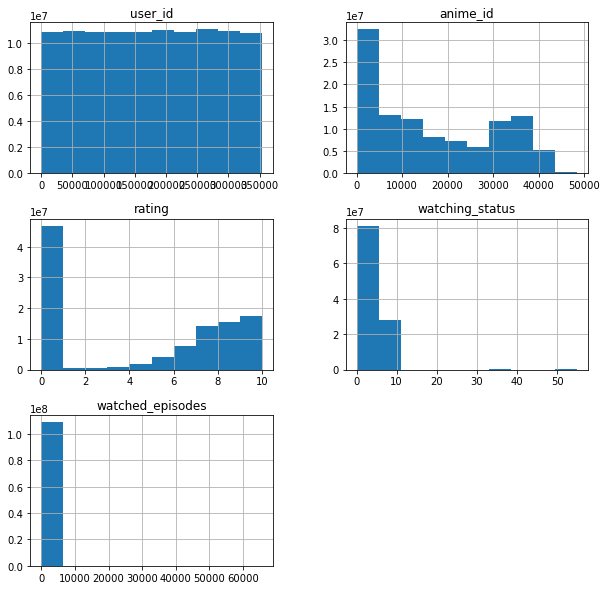

In [19]:
anime_user_ratings.hist(figsize=(10,10));

In [20]:
anime_user_ratings.describe()

,user_id,anime_id,rating,watching_status,watched_episodes
count,1.092247e+08,1.092247e+08,1.092247e+08,1.092247e+08,1.092247e+08
mean,1.768098e+05,1.649590e+04,4.245717e+00,3.087289e+00,1.210818e+01
std,1.018487e+05,1.379737e+04,3.912888e+00,1.774407e+00,1.463155e+02
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.849100e+04,3.194000e+03,0.000000e+00,2.000000e+00,0.000000e+00
50%,1.771420e+05,1.244500e+04,5.000000e+00,2.000000e+00,3.000000e+00
75%,2.651870e+05,3.083100e+04,8.000000e+00,6.000000e+00,1.200000e+01
max,3.534040e+05,4.849200e+04,1.000000e+01,5.500000e+01,6.553500e+04


In [21]:
anime_user_ratings.watching_status.unique()

array([ 1,  2,  3,  4,  6,  0,  5, 33, 55])

### Checking Non-Normal values in watching_status column

In [22]:
anime_user_ratings.groupby('watching_status').size()

watching_status
0          531
1      5228658
2     68089751
3      3700514
4      4266591
5            6
6     27938693
33           2
55           1
dtype: int64

In [23]:
anime_user_ratings[anime_user_ratings['watching_status'] == 0]

,user_id,anime_id,rating,watching_status,watched_episodes
2970875,10015,6682,0,0,0
2970876,10015,18893,0,0,0
2970877,10015,4999,0,0,0
2970878,10015,7817,0,0,0
2970879,10015,6347,0,0,0
...,...,...,...,...,...
103208377,333530,227,0,0,0
103208378,333530,10408,0,0,0
103208379,333530,6045,0,0,0
103208380,333530,24,0,0,0


In [24]:
anime_user_ratings[(anime_user_ratings['watching_status'] == 0) & (anime_user_ratings['rating'] !=0)]



,user_id,anime_id,rating,watching_status,watched_episodes
2970882,10015,18767,7,0,2
2970886,10015,14741,10,0,12
2970889,10015,9479,10,0,13
2970892,10015,12549,7,0,12
2970893,10015,14893,6,0,1
...,...,...,...,...,...
36955269,120049,22043,10,0,12
36955270,120049,11061,10,0,15
36955271,120049,249,10,0,2
36955272,120049,1604,10,0,18


### Checking Non-Normal values in watched_episodes column

In [25]:
anime_user_ratings[anime_user_ratings['watched_episodes'] > 1800]

,user_id,anime_id,rating,watching_status,watched_episodes
186970,631,3221,6,2,9001
194983,656,21,7,1,36600
214838,722,3342,6,2,9001
355037,1125,355,5,2,9001
420236,1371,148,8,2,9001
...,...,...,...,...,...
109042337,352832,12393,0,2,1818
109042948,352832,2406,0,3,7000
109077329,352930,2406,9,1,6688
109104702,353021,149,7,2,9001


In [26]:
anime_df_no_syn[anime_df_no_syn['MAL_ID'] == 21]

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,Cleaned_Name,Year_Premiered
11,21,One Piece,8.52,"Action, Adventure, Comedy, Super Power, Drama,...",One Piece,ONE PIECE,TV,Unknown,"Oct 20, 1999 to ?",Fall 1999,"Fuji TV, TAP, Shueisha","Funimation, 4Kids Entertainment",Toei Animation,Manga,24 min.,PG-13 - Teens 13 or older,95.0,31,1352724,126645,887333,33,187919,136245,141194,292445.0,166186.0,141755.0,85424.0,35342.0,19019.0,8201.0,3675.0,2616.0,6340.0,One Piece,1999


In [27]:
#anime_completed_ratings = anime_user_ratings[anime_user_ratings['watching_status'] == 2]

In [28]:
#anime_completed_ratings.hist(figsize=(10,10));

In [29]:
#anime_completed_ratings.describe()

In [30]:
Top_1000_anime = anime_df_no_syn[anime_df_no_syn['Popularity'] != 0].sort_values('Popularity', ascending=True).head(1000)

In [31]:
len(list(Top_1000_anime.MAL_ID))

1000

In [32]:
anime_id_1000_anime = anime_user_ratings[anime_user_ratings.anime_id.isin(list(Top_1000_anime.MAL_ID))][['user_id', 'anime_id', 'rating']]

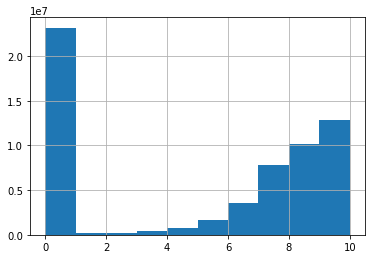

In [33]:
anime_id_1000_anime.rating.hist();

In [34]:
anime_id_1000_anime.groupby('user_id').size().sort_values()

user_id
284067       1
329376       1
215258       1
29881        1
133181       1
          ... 
283786    1000
140590    1000
259885    1000
252520    1000
20807     1000
Length: 323971, dtype: int64

In [35]:
anime_id_1000_anime.replace(0,np.nan, inplace=True)

In [36]:
anime_id_1000_anime.dropna(inplace=True)

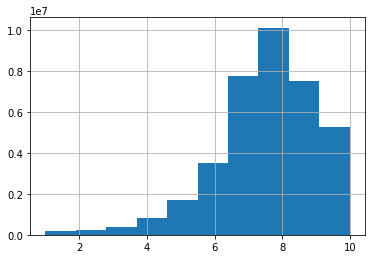

In [37]:
anime_id_1000_anime.rating.hist();

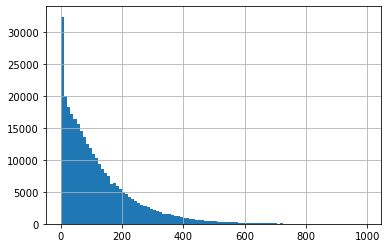

In [38]:
anime_id_1000_anime.groupby('user_id').size().sort_values().hist(bins=100);

In [39]:
anime_id_1000_anime.groupby('user_id').size().describe()

count    311352.000000
mean        120.374843
std         115.994606
min           1.000000
25%          35.000000
50%          87.000000
75%         171.000000
max         995.000000
dtype: float64

In [40]:
filtered_df_1000_anime = anime_id_1000_anime.groupby('user_id').filter(lambda x : len(x)==5)
#filtered_df_1000_anime = filtered_df_1000_anime.groupby('user_id').filter(lambda x : len(x)<171)

In [41]:
filtered_df_1000_anime

,user_id,anime_id,rating
21920,79.0,31043,10.0
21930,79.0,20583,9.0
21943,79.0,23273,10.0
21951,79.0,27899,7.0
21953,79.0,32995,10.0
...,...,...,...
109224715,353404.0,6033,10.0
109224716,353404.0,223,9.0
109224717,353404.0,225,8.0
109224723,353404.0,813,9.0


In [51]:
filtered_df_1000_anime.groupby('rating').size()

rating
1.0      109
2.0       45
3.0       46
4.0      101
5.0      243
6.0      470
7.0     1352
8.0     2468
9.0     3612
10.0    6039
dtype: int64

In [43]:
len(filtered_df_1000_anime.anime_id.unique())

955

# First Model

## Modeling with Surprise

In [44]:
reader = Reader()
data = Dataset.load_from_df(filtered_df_1000_anime, reader)

In [45]:
train, test = train_test_split(data, test_size=.25)

In [46]:
model = SVD()

In [47]:
%%time
model.fit(train)

CPU times: user 592 ms, sys: 4.1 ms, total: 596 ms
Wall time: 599 ms


In [48]:
%%time
accuracy.mae(model.test(test))

MAE:  3.8771
CPU times: user 36.8 ms, sys: 8.4 ms, total: 45.2 ms
Wall time: 39.3 ms


3.877139701822198

In [49]:
params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD, param_grid=params, cv=3, n_jobs=-1, joblib_verbose=5)
g_s_svd.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    6.6s finished


In [50]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 4.064455582817979, 'mae': 3.865033811132216}
{'rmse': {'n_factors': 20, 'reg_all': 0.02}, 'mae': {'n_factors': 20, 'reg_all': 0.02}}
